<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Testing different Hyperparameters and Benchmarking

In this notebook, we'll cover how to test different hyperparameters for a particular dataset and how to benchmark different parameters across a group of datasets. Note that this re-uses functionality which was already introduced and described in the [classification/notebooks/11_exploring_hyperparameters.ipynb](../../classification/notebooks/11_exploring_hyperparameters.ipynb) notebook. **Please refer to that notebook for all explanations, which this notebook will not repeat.**

For an example of how to scale up with remote GPU clusters on Azure Machine Learning, please view [24_exploring_hyperparameters_on_azureml.ipynb](../../classification/notebooks/24_exploring_hyperparameters_on_azureml.ipynb).

## Testing hyperparameters

Ensure edits to libraries are loaded and plotting is shown in the notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We start by importing the utilities we need.

In [2]:
import sys
import numpy as np
import scrapbook as sb
import torch
import fastai
from fastai.vision import *

sys.path.append("../../")
from utils_cv.common.data import unzip_url
from utils_cv.classification.parameter_sweeper import ParameterSweeper, clean_sweeper_df, plot_sweeper_df
from utils_cv.segmentation.data import Urls

fastai.__version__

'1.0.57'

Define the datasets and parameters we will use in this notebook. To run this notebook quickly, we are setting the image resolution and the number of epochs to be low. 

In [3]:
DATA_PATHS = [unzip_url(Urls.fridge_objects_path, exist_ok=True)]
REPS = 3
LEARNING_RATES = [1e-3, 1e-4, 1e-5]
IM_SIZES = [50, 100]   #recommended to try: [300, 500]
EPOCHS = [2,5]         #recommended to try: [10, 20]
DROPOUTS = [0]

### Model training and evaluation

We start by creating the Parameter Sweeper object. Before we start testing, it's a good idea to see what the default parameters are. We can use a the property `parameters` to easily see those default values.

In [4]:
sweeper = ParameterSweeper(metric_name="ratio_correct")
sweeper.parameters

OrderedDict([('learning_rate', [0.0001]),
             ('epochs', [15]),
             ('batch_size', [16]),
             ('im_size', [299]),
             ('architecture',
              [<Architecture.resnet18: functools.partial(<function resnet18 at 0x0000015CAF75E558>)>]),
             ('transform', [True]),
             ('dropout', [0.5]),
             ('weight_decay', [0.01]),
             ('training_schedule',
              [<TrainingSchedule.head_first_then_body: 'head_first_then_body'>]),
             ('discriminative_lr', [False]),
             ('one_cycle_policy', [True])])

Now that we know the defaults, we can pass it the parameters we want to test, and run the parameter sweep.

In [ ]:
sweeper.update_parameters(learning_rate=LEARNING_RATES, im_size=IM_SIZES, epochs=EPOCHS, dropout=DROPOUTS)
df = sweeper.run(datasets=DATA_PATHS, reps=REPS)
df

### Visualize Results <a name="visualize"></a>

When we read in multi-index dataframe, index 0 represents the run number, index 1 represents a single permutation of parameters, and index 2 represents the dataset. To see the results, show the df using the `clean_sweeper_df` helper function. This will display all the hyperparameters in a nice, readable way.

In [6]:
df = clean_sweeper_df(df)

Since we've run our benchmarking over 3 repetitions, we may want to just look at the averages across the different __run numbers__.

In [7]:
df.mean(level=(1,2)).T

,P: [learning_rate: 0.001] [epochs: 2] [im_size: 50],P: [learning_rate: 0.001] [epochs: 2] [im_size: 100],P: [learning_rate: 0.001] [epochs: 5] [im_size: 50],P: [learning_rate: 0.001] [epochs: 5] [im_size: 100],P: [learning_rate: 0.0001] [epochs: 2] [im_size: 50],P: [learning_rate: 0.0001] [epochs: 2] [im_size: 100],P: [learning_rate: 0.0001] [epochs: 5] [im_size: 50],P: [learning_rate: 0.0001] [epochs: 5] [im_size: 100],P: [learning_rate: 1e-05] [epochs: 2] [im_size: 50],P: [learning_rate: 1e-05] [epochs: 2] [im_size: 100],P: [learning_rate: 1e-05] [epochs: 5] [im_size: 50],P: [learning_rate: 1e-05] [epochs: 5] [im_size: 100]
,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects,segFridgeObjects
duration,8.547139,9.013214,16.63577,20.546062,7.172654,8.761727,16.897888,20.728977,7.189551,8.739836,16.870451,20.614386
ratio_correct,0.944444,1.000000,1.00000,1.000000,1.000000,1.000000,0.992063,1.000000,0.837302,0.869048,0.896825,0.968254


Print the average accuracy over the different runs for each dataset independently.

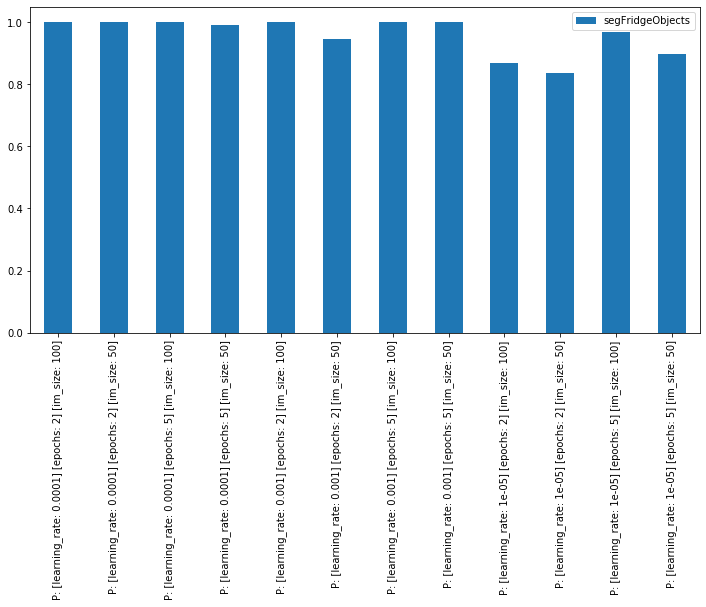

In [8]:
ax = df.mean(level=(1,2))["ratio_correct"].unstack().plot(kind='bar', figsize=(12, 6))

Additionally, we may want simply to see which set of hyperparameters perform the best across the different __datasets__. We can do that by averaging the results of the different datasets.

In [9]:
df.mean(level=(1)).T

,P: [learning_rate: 0.001] [epochs: 2] [im_size: 50],P: [learning_rate: 0.001] [epochs: 2] [im_size: 100],P: [learning_rate: 0.001] [epochs: 5] [im_size: 50],P: [learning_rate: 0.001] [epochs: 5] [im_size: 100],P: [learning_rate: 0.0001] [epochs: 2] [im_size: 50],P: [learning_rate: 0.0001] [epochs: 2] [im_size: 100],P: [learning_rate: 0.0001] [epochs: 5] [im_size: 50],P: [learning_rate: 0.0001] [epochs: 5] [im_size: 100],P: [learning_rate: 1e-05] [epochs: 2] [im_size: 50],P: [learning_rate: 1e-05] [epochs: 2] [im_size: 100],P: [learning_rate: 1e-05] [epochs: 5] [im_size: 50],P: [learning_rate: 1e-05] [epochs: 5] [im_size: 100]
duration,8.547139,9.013214,16.63577,20.546062,7.172654,8.761727,16.897888,20.728977,7.189551,8.739836,16.870451,20.614386
ratio_correct,0.944444,1.000000,1.00000,1.000000,1.000000,1.000000,0.992063,1.000000,0.837302,0.869048,0.896825,0.968254


To make it easier to see which permutation did the best, we can plot the results using the `plot_sweeper_df` helper function. This plot will help us easily see which parameters offer the highest accuracies.

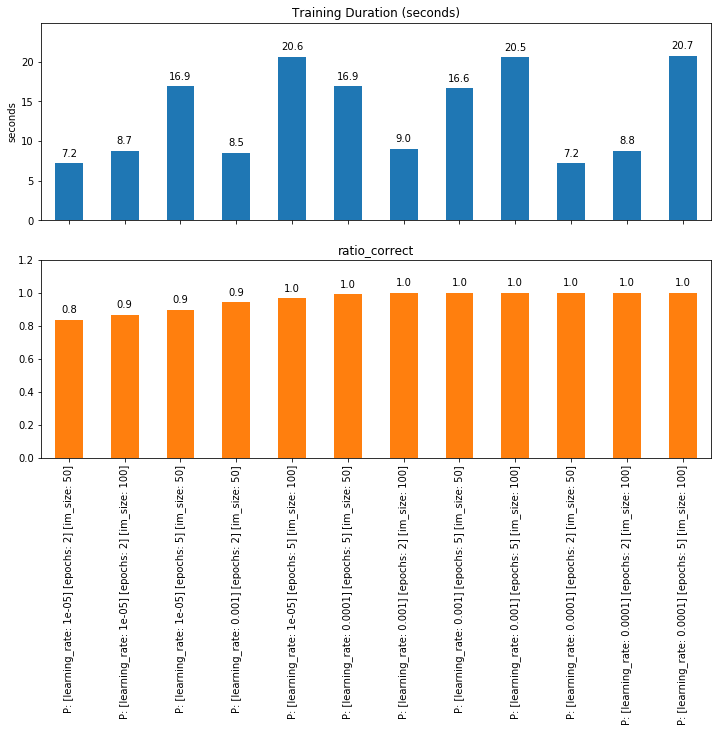

In [10]:
plot_sweeper_df(df.mean(level=(1)), sort_by="ratio_correct")

In [11]:
# Preserve some of the notebook outputs
sb.glue("nr_elements", len(df))
sb.glue("ranks", list(df.mean(level=(1))["ratio_correct"]))
sb.glue("max_duration", df.max().duration)
sb.glue("min_duration", df.min().duration)